In [218]:
#  Import Libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler , StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Bidirectional
from statsmodels.tsa.stattools import adfuller

In [219]:
# Download Yahoo Finance datasets
# Choose Close to analysis
ticker = 'AAPL'
data = yf.download(ticker, start='2010-01-01', end='2024-01-01')
data = data[['Close']]
data.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [220]:
#Show the data
data.head()

Price,Close
Ticker,AAPL
Date,
2010-01-04,6.440331
2010-01-05,6.451466
2010-01-06,6.348846
2010-01-07,6.337109
2010-01-08,6.379241


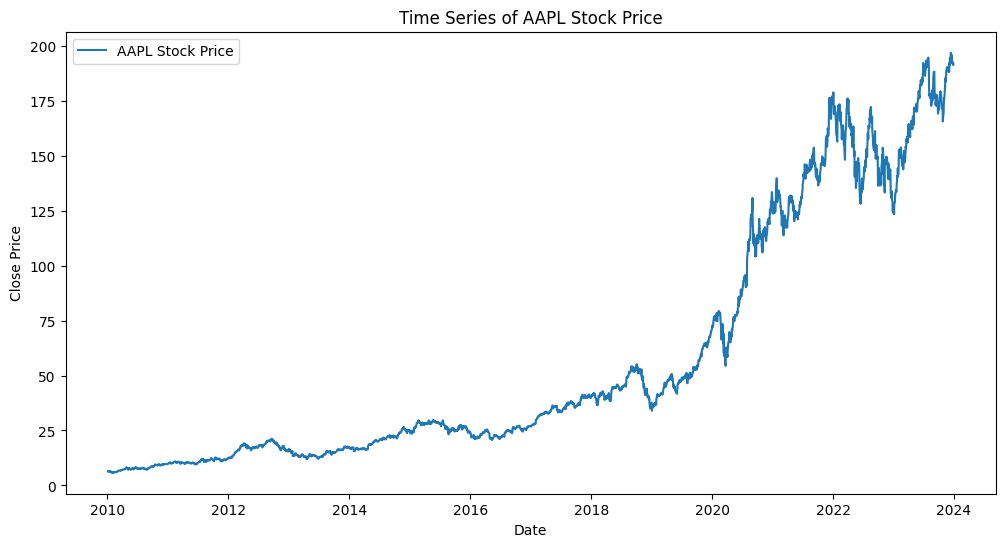

In [221]:
#  Data Analysis and Exploration
plt.figure(figsize=(12,6))
plt.plot(data['Close'], label=f'{ticker} Stock Price')
plt.title(f'Time Series of {ticker} Stock Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [222]:
#  ARIMA Model for Price Prediction

def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')

check_stationarity(data['Close'])

ADF Statistic: 0.9209710742071369
p-value: 0.9933579914917213


In [223]:
# Build ARIMA Model and Predict Prices
model_arima = ARIMA(data['Close'], order=(5,1,0))
model_arima_fit = model_arima.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


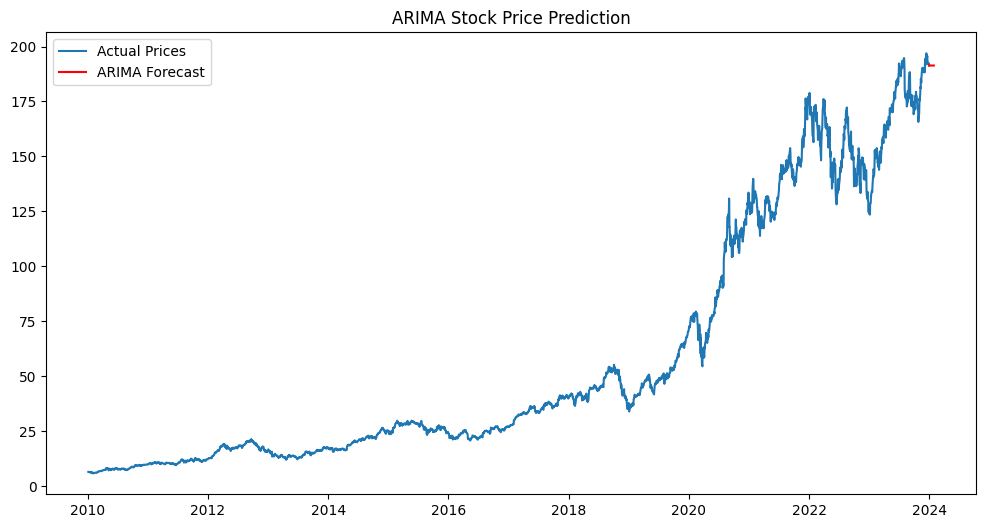

In [224]:
# Future Price Forecast
forecast_arima = model_arima_fit.forecast(steps=30)
plt.figure(figsize=(12,6))
plt.plot(data['Close'], label='Actual Prices')
plt.plot(pd.date_range(data.index[-1], periods=31, freq='D')[1:], forecast_arima, label='ARIMA Forecast', color='red')
plt.legend()
plt.title('ARIMA Stock Price Prediction')
plt.show()

In [225]:
# LSTM Model for Stock Price Prediction
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [226]:
# Prepare LSTM Data
train_size = int(len(data) * 0.8)
train, test = data_scaled[:train_size], data_scaled[train_size:]

def create_dataset(dataset, look_back=60):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 60
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# بناء نموذج LSTM
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(look_back, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [227]:
model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 15s 98ms/step - loss: 0.0078 - val_loss: 0.0028
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - loss: 4.2247e-04 - val_loss: 0.0050
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step - loss: 4.7957e-04 - val_loss: 0.0011
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - loss: 4.1780e-04 - val_loss: 0.0013
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - loss: 3.5454e-04 - val_loss: 0.0037
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 3.0249e-04 - val_loss: 0.0033
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - loss: 4.3694e-04 - val_loss: 0.0034
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 2.6621e-04 - val_loss: 0.0010
Epoch 9/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 2.2419e-04 - val_loss: 0.0024
Epoch 10/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - loss: 2.9324e-04 - val_loss: 7.8567e-04
Epoch 11/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 2.4231e-04 - val_loss: 0.0015
Epoch 12/2

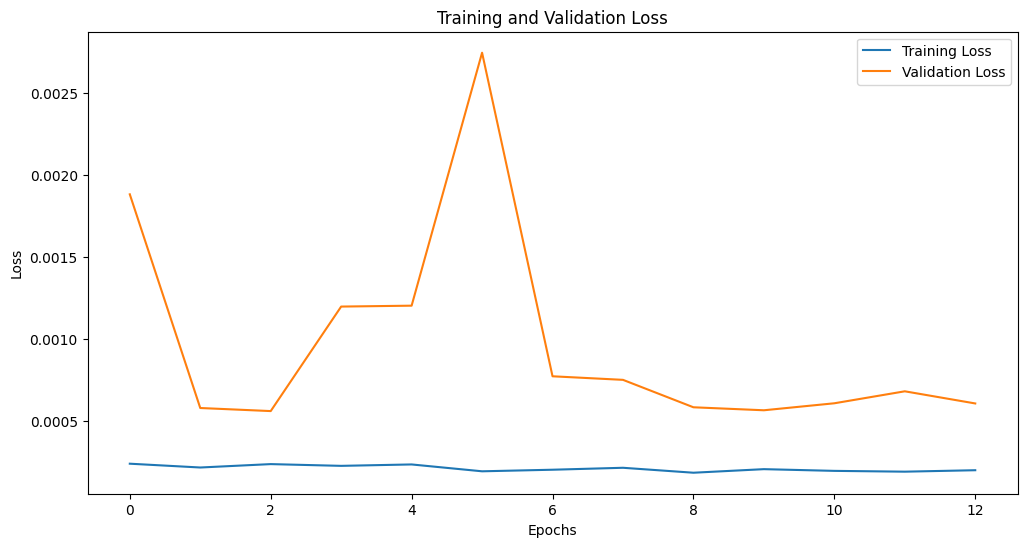

In [230]:
# Plot Training Loss and Validation Loss
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [231]:
# Predict Prices using LSTM
predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


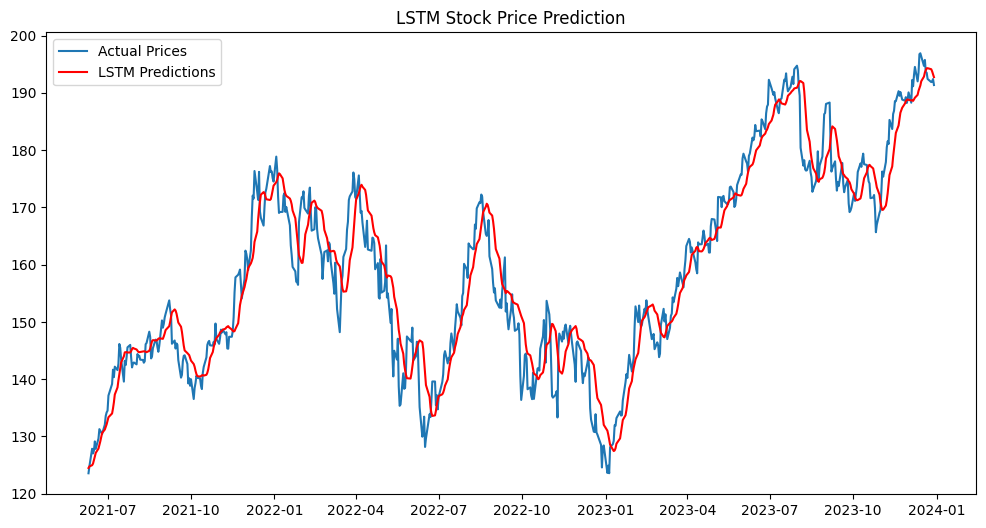

In [233]:
# Display Predictions
plt.figure(figsize=(12,6))
plt.plot(data.index[train_size + look_back + 1:], scaler.inverse_transform(test[look_back+1:]), label='Actual Prices')
plt.plot(data.index[train_size + look_back + 1:], predictions, label='LSTM Predictions', color='red')
plt.legend()
plt.title('LSTM Stock Price Prediction')
plt.show()